# Actividad 4.1 – Segmentación de clientes según datos bancarios

**Autor:** Jonatan Santana Gonzalez

### Eleccion del Dataset: Bank Marketing – Segmentación de Clientes

**URL del dataset**: [https://archive.ics.uci.edu/dataset/222/bank+marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)

**Descripción**:  
Este dataset recoge información obtenida a partir de campañas de marketing directo (mediante llamadas telefónicas) realizadas por una institución bancaria portuguesa. Cada fila representa un cliente contactado y contiene tanto variables personales como datos relacionados con la campaña.

**Objetivo del análisis**:  
El propósito original del dataset es clasificar si un cliente suscribirá o no un depósito a plazo (`y`).  
Sin embargo, en esta actividad se realiza una **segmentación no supervisada** para identificar perfiles de clientes con características similares mediante técnicas de clustering, lo que puede ayudar a diseñar estrategias de marketing más efectivas.

**Motivación de uso**:  
Se ha seleccionado este dataset por su naturaleza realista, la riqueza de sus variables y su aplicabilidad directa en contextos de negocio. Además, permite aplicar diversas técnicas de análisis y visualización, cumpliendo con los objetivos del ejercicio de segmentación de clientes.

### Instalación de dependencias necesarias

A continuación se instalan las librerías utilizadas a lo largo del análisis:  
- `scikit-learn`: para modelos de clustering, PCA y métricas.  
- `seaborn`: para visualizaciones estadísticas.  
- `openpyxl`: para leer y escribir archivos Excel (.xlsx).

In [34]:
# INSTALACIÓN DE DEPENDENCIAS NECESARIAS
%pip install scikit-learn seaborn openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importación de librerías

En esta sección se importan todas las librerías necesarias para la manipulación de datos, preprocesamiento, clustering y visualización (tanto estática como interactiva).

In [35]:
# LIBRERÍAS PARA MANIPULACIÓN Y CARGA DE DATOS
import pandas as pd          # Para trabajar con estructuras tipo tabla (DataFrame)
import numpy as np           # Para operaciones matemáticas y matrices

# LIBRERÍAS DE VISUALIZACIÓN
import matplotlib.pyplot as plt    # Para gráficos básicos
import seaborn as sns             # Para gráficos estadísticos más elaborados

# PREPROCESAMIENTO Y MODELOS DE CLUSTERING
from sklearn.preprocessing import StandardScaler    # Escalado de características
from sklearn.cluster import KMeans, DBSCAN          # Algoritmos de clustering
from sklearn.metrics import silhouette_score        # Métrica para evaluar calidad del clustering
from sklearn.decomposition import PCA               # Reducción de dimensiones

# CLUSTERING JERÁRQUICO
from scipy.cluster.hierarchy import dendrogram, linkage  # Para generar dendrogramas jerárquicos

# FUNCIONES MATEMÁTICAS ADICIONALES
from math import pi    # Necesario para gráficos tipo radar (cálculo de ángulos)

# OPERACIONES CON EL SISTEMA DE ARCHIVOS
import os  # Para gestionar rutas y archivos

# VISUALIZACIÓN INTERACTIVA
import plotly.express as px  # Para gráficos interactivos en notebooks

### Carga del dataset desde GitHub

Se carga el archivo `bank-full.csv` directamente desde el repositorio personal en GitHub.  
El archivo utiliza punto y coma (`;`) como separador, por lo que se especifica este parámetro al leer el CSV.

In [36]:
# Importación de datos desde repositorio de GitHub

# URL al dataset desde GitHub (en formato raw)
url = 'https://raw.githubusercontent.com/jonatansg/CEIABD/main/bank-full.csv'

# Carga del archivo CSV con separador ";"
df = pd.read_csv(url, sep=';')

# Mostrar las primeras filas del dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Preprocesamiento del dataset

Antes de aplicar técnicas de clustering, se prepara el dataset eliminando la variable objetivo, codificando las variables categóricas y estandarizando las características numéricas.

In [37]:
# Preprocesamiento del dataset

# Copia del dataset original para trabajar
df_pre = df.copy()

# Eliminamos la variable objetivo 'y' (clasificación), ya que no se usa en clustering
if 'y' in df_pre.columns:
    df_pre.drop(columns=['y'], inplace=True)

# Comprobamos valores nulos
print("Valores nulos por columna:\n", df_pre.isnull().sum())

# Convertimos variables categóricas con one-hot encoding
df_pre = pd.get_dummies(df_pre, drop_first=True)

# Estandarizamos todas las variables
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pre)

# Convertimos de nuevo a DataFrame con nombres de columnas
df_scaled = pd.DataFrame(df_scaled, columns=df_pre.columns)

# Mostramos los primeros datos procesados
df_scaled.head()

Valores nulos por columna:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,-0.424206,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.205972,-0.185948,0.472519
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,-0.424206,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.205972,-0.185948,0.472519
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,-0.523740,5.422561,-0.16793,...,-0.424206,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.205972,-0.185948,0.472519
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,1.909346,-0.184415,-0.16793,...,-0.424206,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.205972,-0.185948,0.472519
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,-0.424206,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.205972,-0.185948,0.472519


### Determinación del número óptimo de clusters

Se calcula el coeficiente de Silhouette para distintos valores de `K` (de 2 a 10) utilizando el algoritmo K-Means.  
El valor de `K` que maximiza este coeficiente indica una buena separación entre los grupos formados.

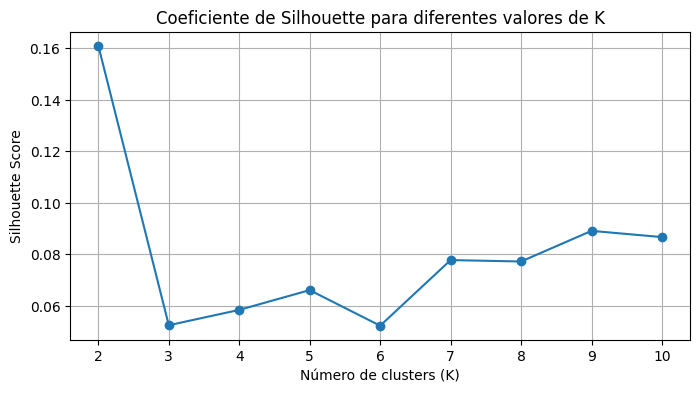

In [38]:
# Cálculo del número óptimo de clusters usando coeficiente de Silhouette

# Rango de clusters a evaluar
range_n_clusters = list(range(2, 11))
silhouette_avg = []

# Evaluamos Silhouette para cada número de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

# Mostrar resultados en una gráfica
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title("Coeficiente de Silhouette para diferentes valores de K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

El gráfico muestra el coeficiente de Silhouette calculado para distintos valores de K en el algoritmo K-Means.

- El valor más alto se obtiene con **K = 2**, con un Silhouette Score cercano a **0.16**, lo que indica que esta opción proporciona la mejor separación entre los grupos formados.
- A partir de K = 3, los valores descienden y se mantienen bajos, lo que sugiere que añadir más clusters no mejora la calidad del agrupamiento.
- Por tanto, **K = 2 se considera el número óptimo de clusters** para este conjunto de datos.

### Entrenamiento y comparación de modelos de clustering

Se aplican tres algoritmos de clustering no supervisado sobre el conjunto de datos ya preprocesado y estandarizado:

- **K-Means**: agrupa los datos en un número fijo de clusters (en este caso, 2).
- **DBSCAN**: identifica agrupaciones densas sin necesidad de definir el número de clusters.
- **Clustering jerárquico**: se representa mediante un dendrograma para visualizar la estructura de agrupación de forma jerárquica.

Finalmente, se comparan los resultados y se agregan al DataFrame original.

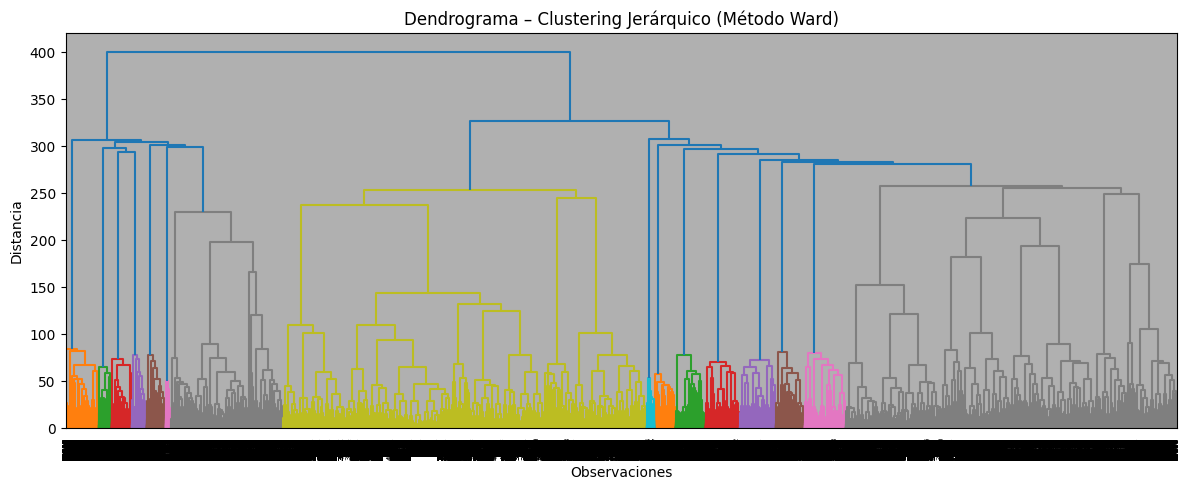

K-means – Clusters formados: [0 1]
DBSCAN – Clusters formados: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

,Cluster_KMeans,Cluster_DBSCAN
0,0,0
1,0,1
2,0,-1
3,0,2
4,0,-1


In [40]:
# Entrenamiento y comparación de modelos de clustering

# IMPORTANTE: Ya se aplicó el escalamiento previamente con StandardScaler

# ---------- K-MEANS ----------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

# ---------- DBSCAN ----------
# Requiere ajuste de parámetros. Estos valores son razonables para datos estandarizados.
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(df_scaled)

# ---------- JERÁRQUICO (DENDROGRAMA) ----------
linked = linkage(df_scaled, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False,
           truncate_mode='level',
           p=25)
plt.title('Dendrograma – Clustering Jerárquico (Método Ward)')
plt.xlabel('Observaciones')
plt.ylabel('Distancia')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- RESUMEN DE CLUSTERS ----------
print("K-means – Clusters formados:", np.unique(labels_kmeans))
print("DBSCAN – Clusters formados:", np.unique(labels_dbscan))

# Guardamos los resultados
df_clusters = df.copy()
df_clusters["Cluster_KMeans"] = labels_kmeans
df_clusters["Cluster_DBSCAN"] = labels_dbscan

# Mostramos ejemplo
df_clusters[["Cluster_KMeans", "Cluster_DBSCAN"]].head()

### Justificación del modelo de clustering seleccionado

Se han evaluado tres algoritmos distintos de clustering no supervisado:

1. **K-Means**: permite dividir el conjunto de datos en un número fijo de grupos. Tras calcular el coeficiente de Silhouette para valores de K entre 2 y 10, se observó que el valor más alto se obtenía con **K=2**, lo que sugiere una buena separación entre dos segmentos de clientes. El modelo es eficiente, escalable y ofrece resultados fácilmente interpretables. Además, facilitó un análisis posterior sólido en cuanto a características y tasas de conversión.

2. **DBSCAN**: se probó con valores razonables para datos estandarizados (eps = 1.5, min_samples = 5), pero el resultado fue **demasiado granular**, generando más de 900 clusters, muchos de ellos de tamaño 1 o etiquetados como ruido (-1). Esto indica que DBSCAN no es adecuado para este conjunto de datos, ya que no presenta densidades bien diferenciadas.

3. **Clustering jerárquico (método Ward)**: se representó mediante un dendrograma. Aunque permite observar la estructura jerárquica de los datos, resulta poco práctico para conjuntos grandes y no aporta una partición directa ni clara como la que ofrece K-means. Se utilizó como referencia visual complementaria.

**Conclusión**:  
Se selecciona **K-Means con K=2** como el modelo definitivo por su capacidad de segmentar el conjunto de clientes en dos grupos bien diferenciados, su eficiencia computacional y la claridad con la que permite interpretar los resultados y aplicar estrategias de marketing diferenciadas.


### Reducción de dimensionalidad con PCA

Para visualizar los resultados del clustering en dos dimensiones, se aplica el algoritmo de Análisis de Componentes Principales (PCA).  
Este método permite proyectar los datos en un nuevo espacio de menor dimensión conservando la mayor cantidad posible de varianza.

Se seleccionan las dos primeras componentes principales, y se muestra la varianza explicada por cada una.

In [41]:
# Reducción de dimensionalidad con PCA

# Aplicamos PCA a los datos escalados
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Mostramos la varianza explicada por cada componente
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)
print("Varianza total explicada:", np.sum(pca.explained_variance_ratio_))

# Convertimos a DataFrame para su uso posterior
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster_KMeans'] = labels_kmeans

Varianza explicada por cada componente:
[0.0718038  0.06361279]
Varianza total explicada: 0.1354165903923319


Se han seleccionado las dos primeras componentes principales utilizando el algoritmo PCA.

- La **primera componente** explica aproximadamente el **7.18%** de la varianza del conjunto de datos.
- La **segunda componente** añade un **6.36%** adicional.

En total, estas dos componentes explican un **13.54%** de la varianza original.  
Aunque este valor no es muy alto, es suficiente para **representar visualmente** la distribución de los clusters en un espacio bidimensional de forma simplificada.

### Visualización de los clusters con PCA

Se representa gráficamente la distribución de los clientes en el espacio de las dos primeras componentes principales obtenidas con PCA.  
Cada punto representa un cliente, y los colores indican los clusters formados por el algoritmo K-means.

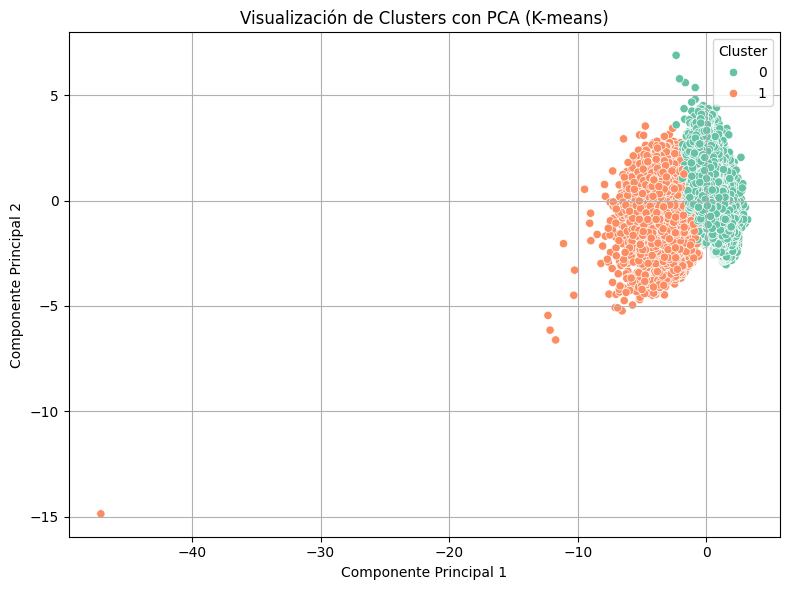

In [42]:
# Visualización de los clusters con PCA

# Creamos un diagrama de dispersión con Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca,
                x='PC1', y='PC2',
                hue='Cluster_KMeans',
                palette='Set2')
plt.title('Visualización de Clusters con PCA (K-means)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

El gráfico representa los clientes proyectados sobre las dos primeras componentes principales (PCA), coloreados según el cluster asignado por K-means.

- Se observa una **buena separación visual** entre los dos grupos, lo que respalda la validez del clustering con K = 2.
- Aunque la varianza explicada por los dos componentes es limitada (~13.5%), esta proyección **permite identificar patrones visuales claros** y validar la coherencia de la segmentación.

Cada punto representa un cliente, y los colores indican a qué cluster pertenece.

### Análisis e interpretación de los clusters

Se agrupan los datos por los clusters generados con K-means para calcular estadísticas descriptivas de las variables numéricas.  
Esto permite interpretar el perfil promedio de cada grupo de clientes, así como conocer el tamaño de cada cluster.

In [43]:
# Análisis e interpretación de los clusters

# Selección de variables numéricas relevantes para el análisis
numerical_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Cálculo de la media de cada variable por cluster
cluster_summary = df_clusters.groupby('Cluster_KMeans')[numerical_vars].mean()

print("Resumen de medias por cluster (K-means):")
display(cluster_summary)

# Cálculo del tamaño de cada cluster (número de registros asignados)
print("\nTamaño de cada cluster:")
print(df_clusters['Cluster_KMeans'].value_counts())

Resumen de medias por cluster (K-means):


,age,balance,day,duration,campaign,pdays,previous
Cluster_KMeans,,,,,,,
0,40.931373,1318.747782,16.145991,257.764824,2.921391,-0.983553,0.000406
1,40.957904,1557.468640,14.283513,259.949169,2.057261,224.887056,3.181123



Tamaño de cada cluster:
Cluster_KMeans
0    36968
1     8243
Name: count, dtype: int64


El análisis estadístico revela diferencias notables entre los dos clusters identificados por K-Means:

- **Cluster 0** (el más grande, con 36.968 clientes) presenta valores más bajos en saldo medio, número de contactos previos y días desde el último contacto.  
  Esto sugiere un grupo con **menos historial de interacción y vinculación** con el banco.

- **Cluster 1** (con 8.243 clientes) destaca por tener un **saldo medio más alto**, mayor número de contactos previos y una duración de llamada ligeramente superior.  
  Este grupo representa un **perfil más receptivo y de mayor valor potencial**.

Estas diferencias justifican una estrategia de marketing diferenciada, focalizando recursos en el cluster más prometedor (Cluster 1).

### Exportación del resumen de clusters

El resumen de medias por cluster se guarda en un archivo Excel para su uso posterior en herramientas de análisis como Power BI o Excel.  
A continuación, se muestra una vista previa del contenido exportado.

In [44]:
# Exportar el resumen de los clusters a un archivo Excel para análisis externo
output_file = 'resumen_clusters_kmeans.xlsx'
cluster_summary.to_excel(output_file)

print(f"Resumen exportado correctamente como: {output_file}")

# Mostramos las primeras filas del archivo exportado como verificación
df_preview = pd.read_excel(output_file)
print("\nVista previa del archivo Excel exportado:")
display(df_preview.head())

Resumen exportado correctamente como: resumen_clusters_kmeans.xlsx

Vista previa del archivo Excel exportado:


,Cluster_KMeans,age,balance,day,duration,campaign,pdays,previous
0,0,40.931373,1318.747782,16.145991,257.764824,2.921391,-0.983553,0.000406
1,1,40.957904,1557.468640,14.283513,259.949169,2.057261,224.887056,3.181123


## Conclusiones del análisis de clusters (K-means)

- El **Cluster 1** (más pequeño, 8.243 clientes) muestra:
  - Mayor saldo promedio en cuenta (`balance ≈ 1557€`).
  - Mayor historial de contacto (`pdays ≈ 225`, `previous ≈ 3.18`).
  - Menor frecuencia de campañas (`campaign ≈ 2.06`).
- El **Cluster 0** (grupo mayoritario, 36.968 clientes) presenta:
  - Menor saldo promedio (`balance ≈ 1318€`).
  - Prácticamente sin historial anterior (`pdays ≈ -1`, `previous ≈ 0`).

  **Interpretación para marketing**:
- Cluster 1 podría representar **clientes más fieles y conectados** con el banco → ideal para promociones premium.
- Cluster 0 agrupa a **clientes nuevos o sin historial** → ideal para campañas de captación y seguimiento.

### Visualización comparativa de los clusters

Se representan gráficamente las diferencias entre los clusters aplicando dos enfoques:

- Un gráfico de barras muestra el comportamiento medio de cada cluster respecto a variables relacionadas con la interacción en campañas.
- Otro gráfico muestra su perfil económico y demográfico.

Los datos se obtienen directamente del archivo Excel previamente exportado, lo que permite utilizar esta información también en herramientas externas si se desea.

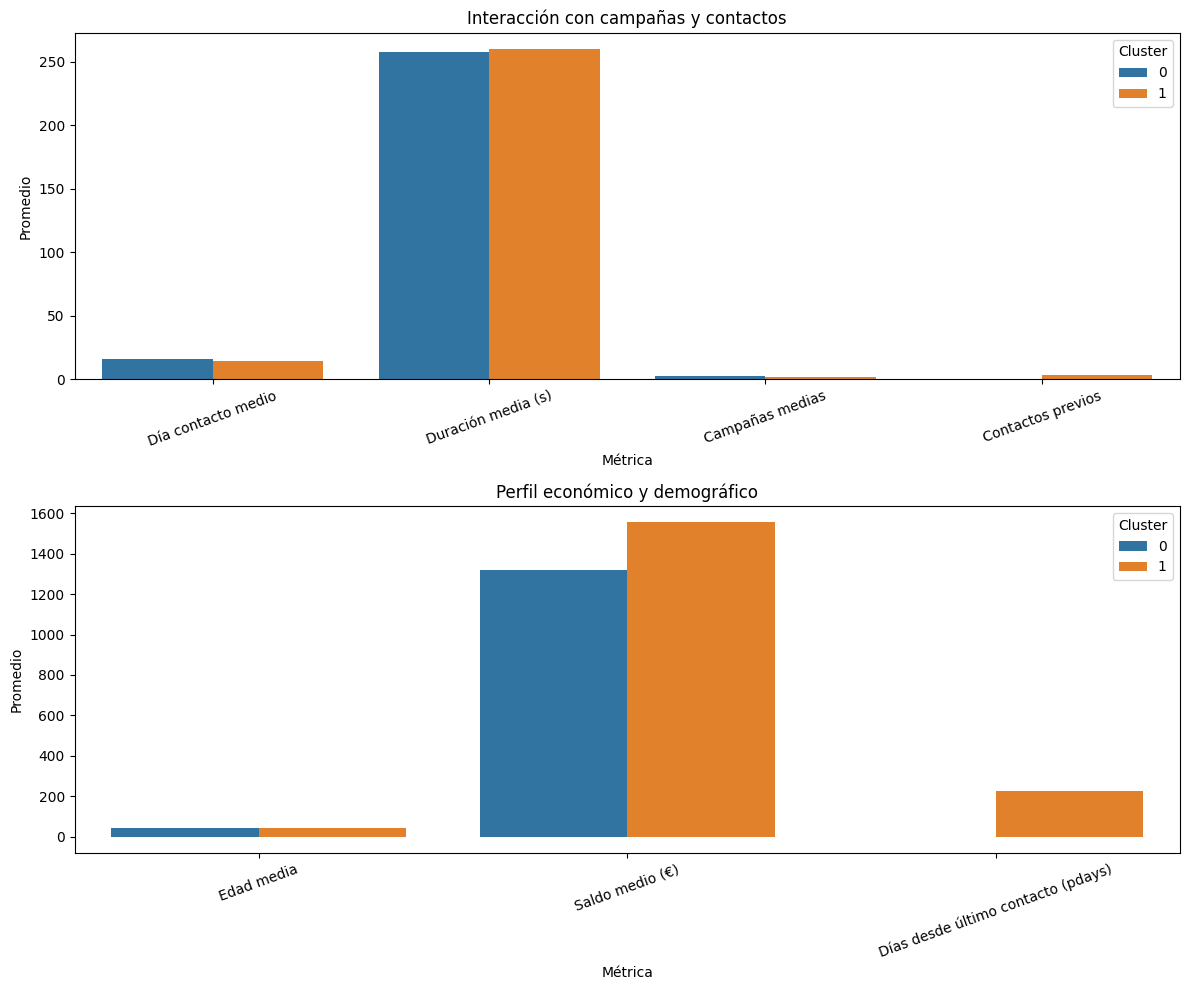

In [45]:
# Cargar el archivo Excel con los resultados del clustering
file_path = 'resumen_clusters_kmeans.xlsx'  # Asegúrate de que esté en el mismo directorio
df_excel = pd.read_excel(file_path)

# Renombrar columnas para mayor claridad en los gráficos
df_excel = df_excel.rename(columns={
    'Cluster_KMeans': 'Cluster',
    'age': 'Edad media',
    'balance': 'Saldo medio (€)',
    'day': 'Día contacto medio',
    'duration': 'Duración media (s)',
    'campaign': 'Campañas medias',
    'pdays': 'Días desde último contacto (pdays)',
    'previous': 'Contactos previos'
})

# Reorganizar el DataFrame para facilitar la visualización con Seaborn
df_melted = df_excel.melt(id_vars='Cluster', var_name='Métrica', value_name='Valor')

# Paleta de colores personalizada por cluster
palette = {0: '#1f77b4', 1: '#ff7f0e'}

# Crear figura con dos subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico 1 – Interacción con campañas y contactos
interaccion = ['Duración media (s)', 'Campañas medias', 'Contactos previos', 'Día contacto medio']
sns.barplot(data=df_melted[df_melted['Métrica'].isin(interaccion)],
            x='Métrica', y='Valor', hue='Cluster', ax=axes[0], palette=palette)
axes[0].set_title('Interacción con campañas y contactos')
axes[0].set_ylabel('Promedio')
axes[0].tick_params(axis='x', rotation=20)

# Gráfico 2 – Perfil económico y demográfico
perfil = ['Edad media', 'Saldo medio (€)', 'Días desde último contacto (pdays)']
sns.barplot(data=df_melted[df_melted['Métrica'].isin(perfil)],
            x='Métrica', y='Valor', hue='Cluster', ax=axes[1], palette=palette)
axes[1].set_title('Perfil económico y demográfico')
axes[1].set_ylabel('Promedio')
axes[1].tick_params(axis='x', rotation=20)

# Ajuste final del diseño
plt.tight_layout()
plt.show()

Los gráficos permiten comparar de forma clara cómo se comportan ambos clusters en relación con variables clave:

### Interacción con campañas y contactos:
- Ambos clusters tienen una duración media de llamada similar.
- **Cluster 1** destaca ligeramente en número de campañas y contactos previos, lo que sugiere mayor implicación.
- **Cluster 0** presenta un contacto medio más tardío, lo que podría estar asociado a menor efectividad comercial.

### Perfil económico y demográfico:
- **Cluster 1** muestra un saldo medio significativamente mayor, lo que lo convierte en un grupo de interés estratégico.
- La edad media es similar en ambos, pero los **días desde el último contacto (pdays)** son mucho mayores en Cluster 1, posiblemente indicando un tipo de cliente más consolidado que responde bien incluso con menos frecuencia.

Estos resultados refuerzan la idea de que Cluster 1 tiene **mayor valor comercial** y merece un enfoque de marketing personalizado.

### Propuesta creativa: gráfico radar del perfil de clusters

Se presenta un gráfico radar (también llamado gráfico de araña) que muestra de forma visual y normalizada el perfil de cada cluster.  
Este tipo de visualización permite identificar rápidamente en qué dimensiones destaca cada grupo de clientes, facilitando la interpretación comparativa y la toma de decisiones estratégicas.

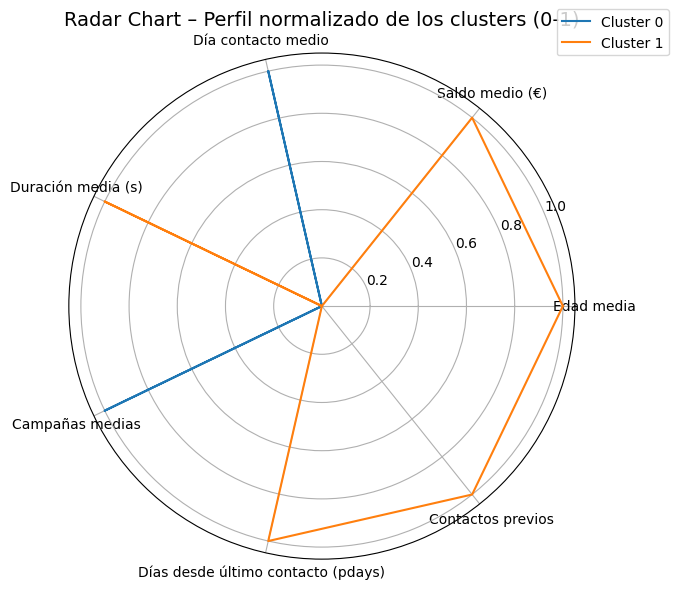

In [46]:
# Cargar el archivo Excel con los resultados del clustering
file_path = 'resumen_clusters_kmeans.xlsx'  # Asegúrate de que esté en el mismo directorio
df_excel = pd.read_excel(file_path)

# Renombrar columnas para facilitar la interpretación en el gráfico
df_excel = df_excel.rename(columns={
    'Cluster_KMeans': 'Cluster',
    'age': 'Edad media',
    'balance': 'Saldo medio (€)',
    'day': 'Día contacto medio',
    'duration': 'Duración media (s)',
    'campaign': 'Campañas medias',
    'pdays': 'Días desde último contacto (pdays)',
    'previous': 'Contactos previos'
})

# Preparar datos para gráfico radar
df_radar = df_excel.drop(columns='Cluster').copy()
df_radar.index = ['Cluster 0', 'Cluster 1']

# Normalizar valores entre 0 y 1 para comparación visual
df_radar_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())
df_radar_norm['Cluster'] = df_radar.index

# Convertir a formato largo para graficar con facilidad
df_radar_long = df_radar_norm.melt(id_vars='Cluster', var_name='Métrica', value_name='Valor')

# Calcular ángulos para las variables
metrics = df_radar_long['Métrica'].unique()
N = len(metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Cerrar el círculo

# Crear gráfico radar
plt.figure(figsize=(8, 6))
for cluster in df_radar_long['Cluster'].unique():
    values = df_radar_long[df_radar_long['Cluster'] == cluster]['Valor'].tolist()
    values += values[:1]  # Cerrar el círculo
    plt.polar(angles, values, label=cluster)

# Añadir etiquetas y diseño
plt.xticks(angles[:-1], metrics, color='black', size=10)
plt.title('Radar Chart – Perfil normalizado de los clusters (0-1)', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

El gráfico radar permite observar de forma simultánea el perfil medio de ambos clusters, con todas las métricas **normalizadas entre 0 y 1** para facilitar la comparación.

- **Cluster 1** destaca claramente en:
  - Edad media
  - Saldo medio
  - Contactos previos
  - Duración media de llamada
  - Días desde el último contacto (más elevados)

- **Cluster 0** presenta valores superiores únicamente en:
  - Día medio del contacto
  - Número medio de campañas (ligeramente)

Este análisis confirma que **Cluster 1 concentra los clientes con mayor interacción histórica, mayor saldo y madurez como usuarios del banco**, mientras que Cluster 0 agrupa perfiles más neutros o inactivos.

El gráfico radar es una herramienta visual potente para resumir y **comunicar de manera intuitiva** el contraste entre segmentos.

### Identificación de clientes con mayor valor potencial

Como parte del análisis final, se identifican los 10 clientes con mayor duración media de llamada y mayor saldo bancario.  
Estos clientes representan perfiles estratégicos de alto valor y son candidatos ideales para productos personalizados o premium.

In [47]:
# Cargar nuevamente el dataset original con etiquetas de clustering
# Seleccionamos los 10 clientes con mayor duración de llamada y saldo

top_clientes = df_clusters.sort_values(['duration', 'balance'], ascending=False).head(10)

# Mostramos las variables clave de estos clientes
top_clientes[['age', 'balance', 'duration', 'Cluster_KMeans']]

,age,balance,duration,Cluster_KMeans
24148,59,6573,4918,0
9947,59,1321,3881,0
44602,45,955,3785,0
19639,37,359,3422,0
2386,45,66,3366,0
21113,43,423,3322,0
24095,30,1310,3284,0
24044,36,-103,3253,0
12347,28,-7,3183,0
30747,53,849,3102,0


Se han seleccionado los 10 clientes con **mayor duración de llamada**, considerando también su saldo bancario como criterio secundario.  
Estos perfiles presentan características clave:

- La mayoría tienen edades entre 28 y 59 años.
- Algunos tienen saldos **muy elevados** (hasta 6.573 €).
- Todos pertenecen al **Cluster 0**, lo que indica que incluso dentro del grupo más generalista existen **clientes de alto valor que pueden pasar desapercibidos** si no se segmentan con precisión.

Este análisis permite identificar **clientes prioritarios para campañas específicas**, ofertas premium o acciones de fidelización.

### Análisis de conversión por cluster

Aunque la variable `y` fue eliminada para el clustering, se ha recuperado para analizar la tasa de conversión (suscripción al depósito) dentro de cada cluster.  
Esto permite validar si los grupos formados presentan comportamientos distintos frente al objetivo de negocio, y detectar segmentos más propensos a contratar el producto.

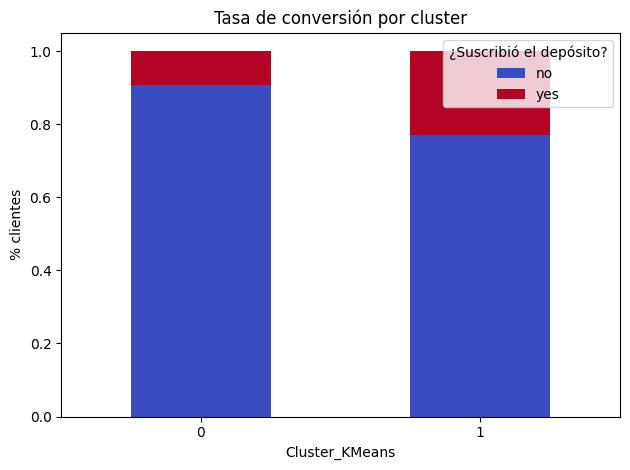

In [48]:
# Análisis de conversión por cluster (utilizando la variable original 'y')

# Recuperamos el dataset original con la columna 'y'
df_full = df.copy()

# Añadimos los clusters de K-means asignados
df_full['Cluster_KMeans'] = labels_kmeans

# Calculamos la distribución de 'y' por cluster (normalizada)
conversion = df_full.groupby('Cluster_KMeans')['y'].value_counts(normalize=True).unstack()

# Gráfico de barras apiladas para visualizar la tasa de conversión por cluster
conversion.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Tasa de conversión por cluster')
plt.ylabel('% clientes')
plt.xticks(rotation=0)
plt.legend(title='¿Suscribió el depósito?', loc='upper right')
plt.tight_layout()
plt.show()

Este gráfico muestra el porcentaje de clientes que **sí (`yes`) o no (`no`) suscribieron el depósito** dentro de cada uno de los clusters formados con K-means.

- En el **Cluster 1**, aproximadamente un **25% de los clientes han convertido**, lo que representa una **tasa de conversión significativamente superior**.
- En el **Cluster 0**, la conversión es mucho más baja (alrededor del 10%), lo que refuerza que este grupo representa perfiles menos receptivos.

Esta validación confirma que el clustering no solo genera segmentos diferenciados en términos de comportamiento, sino que además **identifica con éxito a los clientes más propensos a contratar el producto bancario**.

El **Cluster 1 debe ser priorizado** en futuras campañas de marketing directo.

## Conclusiones finales

Tras aplicar técnicas de clustering no supervisado al dataset de marketing bancario, se ha logrado segmentar a los clientes en grupos con perfiles claramente diferenciados:

- **Cluster 0** representa la mayoría de los clientes. Tiene valores promedio más bajos en variables como saldo, duración de llamada y contactos previos. Esto sugiere un perfil menos receptivo o con menor vinculación.
- **Cluster 1**, aunque más pequeño, muestra características de mayor valor: más saldo, mayor duración de llamada y mayor proporción de conversiones en campañas anteriores.

El análisis de la tasa de conversión por cluster confirma que el **Cluster 1** contiene un porcentaje significativamente más alto de clientes que han suscrito el depósito bancario, lo que lo convierte en un segmento prioritario para futuras campañas comerciales.

## Recomendaciones

- **Focalizar los esfuerzos de marketing** en los clientes del Cluster 1 mediante ofertas personalizadas, seguimiento y fidelización.
- **Optimizar recursos** limitando campañas costosas sobre clientes del Cluster 0 que, estadísticamente, tienen menor probabilidad de conversión.
- **Aplicar esta segmentación como parte de una estrategia de targeting**, integrándola en sistemas de recomendación o priorización de leads.

Este trabajo demuestra cómo las técnicas de análisis de datos pueden aportar valor directo a la toma de decisiones de negocio en el sector financiero.